# Deep Learning for tabular data augmentation

### How to use a variational Autoencoder to augment tabular data

When it comes to DeepLearning, the more data we have the better the chances are to get a great performing model. In fields like image recognition research has already came up with quite a few clever ideas how to use the existing data to create more data out of it. This is called data augmentation. 

However, when we look at Deep Learning in the tabular data context, there are still many concepts missing. What I would like to show in this blogpost is a way to augment tabular data, what we could use in order to train a DeepLearning Model on more tabular data, or which can be used to create data of underrepresented classes. 

I want to show graphically how this newly created data is sampled from the distribution of the underlying data and hence how this data can help to make better Deep Learning models.

I've already created a small library, which I called deep_tabular_augmentation. In here I've created a class, which handles all of the tabular data augmentation.

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import deep_tabular_augmentation as dta
import warnings; warnings.simplefilter('ignore')

So first, we need to get some data. Here, I've got some data on the infamous wine-dataset.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = 'data/wine.csv'

df = pd.read_csv(DATA_PATH, sep=',')

df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
cols = df.columns

We then build a DataLoader, in which we also standardize our data. We save the scaler in our dataset to make use of it later, when we invert the scaling.

In [4]:
def load_and_standardize_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    df = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   
    return X_train, X_test, scaler

In [5]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(DATA_PATH)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [6]:
traindata_set=DataBuilder(DATA_PATH, train=True)
testdata_set=DataBuilder(DATA_PATH, train=False)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

In [7]:
trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([124, 14]), torch.Size([54, 14]))

We've build our train and test datasets, and with the help of DataLoaders we also turned them into tensors. So, let's use deep_tabular_augmentation now. The class needs seven inputs: trainloader, testloader, device on which to run the traning, the input dimension (in this case: 14), and how many nodes the first and second hidden layers should have. Finally, we can also specify the number of latent factors. These latent factors will contain all the condensed information, meaning that we can use these latent factors to recreate the original 14 input dimensions (e.g. our data).

In [58]:
D_in = traindata_set.x.shape[1]
H = 50
H2 = 12

autoenc_model = dta.AutoencoderModel(trainloader, testloader, device, D_in, H, H2, latent_dim=3)

After we've successfully initiated our model, let's train it and call the trained model "autoenc_model_fit".

In [59]:
autoenc_model_fit = autoenc_model.fit(epochs=600)

====> Epoch: 200 Average training loss: 11.3281
====> Epoch: 200 Average test loss: 11.4239
====> Epoch: 400 Average training loss: 9.7651
====> Epoch: 400 Average test loss: 10.3157
====> Epoch: 600 Average training loss: 9.1283
====> Epoch: 600 Average test loss: 10.5291


Now, all we need is to create some fake data based on the trained model. How this works is the following: we know the learned parameters for the mean and the variance of our latent factors. Then, we use a normal distribution with the mean and variance of each of the latent factors to sample a value for latent factor 1,2 and 3 (because we've got three latent facots in this case). These generated starting points for our latent factors are then used to inflate towards the 14 real input variables. Let's see how it's done:

In [60]:
scaler = trainloader.dataset.standardizer
df_fake = autoenc_model_fit.predict(no_samples=500, scaler=scaler, cols=cols)
df_fake['Wine'] = np.round(df_fake['Wine']).astype(int)
df_fake['Wine'] = np.where(df_fake['Wine']<1, 1, df_fake['Wine'])
df_fake['Wine'] = np.where(df_fake['Wine']>3, 3, df_fake['Wine'])
df_fake.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,2,12.493084,2.045130,2.237029,18.645376,101.227913,2.366858,2.039845,0.310666,1.780123,3.824865,1.053821,2.959614,614.468567
1,2,12.388008,2.028943,2.237992,19.671783,93.292801,2.290553,2.102422,0.337810,1.582847,3.545685,1.047288,2.853665,574.657776
2,2,12.863456,2.061298,2.315192,18.529932,104.701004,2.480082,2.273354,0.298898,1.788156,4.134489,1.071253,2.954578,788.806580
3,2,12.315710,2.164225,2.261593,20.433725,91.778603,2.019248,1.704518,0.383477,1.496545,3.532443,0.991632,2.591641,531.966309
4,2,12.562940,2.135798,2.234170,19.034275,101.889763,2.421708,2.133960,0.296481,1.818705,3.890027,1.052557,2.903332,662.883545


The deep_tabular_augmentation library has another method in its sleeve: predict_with_noise. What this does is the following, sampling from a normal distribution each element (independend of each other element) will be multiplied by 1 plus the sampled number. Why should we do this? The answer is that the Variational Autoencoder works similar to a PCA, resulting in sharper defined relations between variables. So the Variational Autoencoder keeps mean and standard deviance within the variables, however, the trained parameters of the model already find out "hidden" relations between variables. When these relations are linear the Variational Autoencoder de facto performs a PCA. We'll have a look at it in a second.

In [61]:
df_fake_with_noise = autoenc_model_fit.predict_with_noise(no_samples=500, scaler=scaler, cols=cols, mu=0, sigma=0.05, group_var='Wine')
df_fake_with_noise['Wine'] = np.round(df_fake_with_noise['Wine']).astype(int)
df_fake_with_noise['Wine'] = np.where(df_fake_with_noise['Wine']<1, 1, df_fake_with_noise['Wine'])
df_fake_with_noise['Wine'] = np.where(df_fake_with_noise['Wine']>3, 3, df_fake_with_noise['Wine'])
df_fake_with_noise.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,2,12.106316,2.142077,2.127616,19.408381,92.179733,2.418110,2.124110,0.353460,1.544483,3.348948,1.057455,2.828610,560.824158
1,2,12.147018,2.009001,2.188961,22.396885,101.379967,2.318827,2.177448,0.336155,1.584168,3.603321,0.984947,2.718268,604.860901
2,2,13.262069,1.864855,2.277317,19.010958,95.259872,2.493481,2.209520,0.347245,1.750477,3.704191,0.989856,2.743370,631.236572
3,2,13.586826,2.270907,2.191374,22.129240,91.323662,1.793574,1.240703,0.437917,1.393128,3.973017,0.862660,2.276499,543.781311
4,2,13.825186,1.984307,2.333792,18.083511,102.420219,2.705270,2.401335,0.312623,1.910688,4.119694,1.008278,3.032777,685.976562


Let's have a look at the descriptives, especially the mean. Can you spot a difference between the real and the fake data?

In [62]:
df.groupby('Wine').describe().loc[:,(slice(None),['mean'])]

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Wine,,,,,,,,,,,,,
1,13.744746,2.010678,2.455593,17.037288,106.338983,2.840169,2.982373,0.290000,1.899322,5.528305,1.062034,3.157797,1115.711864
2,12.278732,1.932676,2.244789,20.238028,94.549296,2.258873,2.080845,0.363662,1.630282,3.086620,1.056282,2.785352,519.507042
3,13.153750,3.333750,2.437083,21.416667,99.312500,1.678750,0.781458,0.447500,1.153542,7.396250,0.682708,1.683542,629.895833


In [63]:
df_fake.groupby('Wine').describe().loc[:,(slice(None),['mean'])]

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Wine,,,,,,,,,,,,,
1,13.756567,1.972927,2.439609,16.679155,110.221558,2.888496,2.933521,0.296994,1.980520,5.707772,1.065832,3.040885,1103.145508
2,12.550643,2.169043,2.292549,19.789505,96.663307,2.250596,2.012712,0.350111,1.627728,3.967775,1.007894,2.744052,616.919006
3,13.225099,3.809655,2.512825,22.554857,101.781906,1.470288,0.664501,0.507955,0.921151,7.329511,0.642636,1.483876,621.194458


In [64]:
df_fake_with_noise.groupby('Wine').describe().loc[:,(slice(None),['mean'])]

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Wine,,,,,,,,,,,,,
1,13.816388,1.980611,2.445411,16.888805,109.618469,2.890874,2.916224,0.297376,1.960559,5.643065,1.068307,3.012105,1106.231079
2,12.554925,2.182181,2.296422,19.779770,96.850357,2.270568,2.013577,0.349725,1.625649,4.029018,1.005889,2.740945,626.561035
3,13.099731,3.869962,2.526824,22.768381,102.265625,1.440060,0.597155,0.517642,0.879244,7.493037,0.621761,1.406803,605.561829


Now let's have a graphic look on how the fake data looks vs the real data.

![alt text](images/alcohol_vs_hue_3.PNG)

This is what I meant by "performing a PCA". One can clearly see how the Variational Autoencoder gave structure to the relation of Alcohol and Hue. If we add noise to it, this relation vanishes. But what happens, if we use more than 3 latent factors? This is the result with 14 (=input variables) latent factors:

![alt text](images/alcohol_vs_hue_14.PNG)

The same pattern emerges. However, when applying random noise to it, the resulting data looks pretty much like the real data.

Now let's have a look at some distributions. The first image always represents the results with 3 latent factors, the second one with 14 latent factors.

### 3 latent factors

![alt text](images/alcohol_dist_3.PNG)

### 14 latent factors

![alt text](images/alcohol_dist_14.PNG)

### 3 latent factors

![alt text](images/color_int_dist_3.PNG)

### 14 latent factors

![alt text](images/color_int_dist_14.PNG)

### 3 latent factors

![alt text](images/flavanoids_dist_3.PNG)

### 14 latent factors

![alt text](images/flavanoids_dist_14.PNG)

We see that when using a Variational Autoencoder to make data augmentation on tabular data, it actually already finds relations between variables. If we want to get rid of this effect and add random noise to the data, the resulting distributions look pretty much like the original, real data points. How can we use these insights to improve machine learning/deep learning models? This I will cover in an upcoming blogpost.

Until then, stay tuned for more!
Lasse

### Appendix

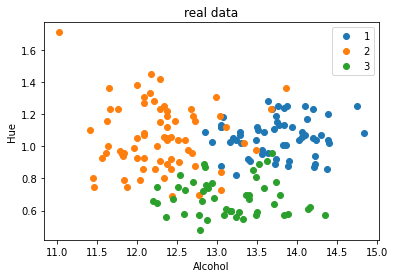

In [65]:
import matplotlib.pyplot as plt

groups = df.groupby('Wine')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Alcohol, group.Hue, marker='o', linestyle='', ms=6, label=name)
ax.legend()
plt.title('real data')
plt.xlabel('Alcohol')
plt.ylabel('Hue')
plt.show()

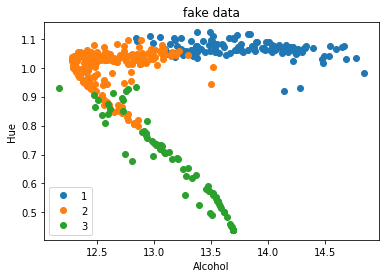

In [66]:
groups = df_fake.groupby('Wine')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Alcohol, group.Hue, marker='o', linestyle='', ms=6, label=name)
ax.legend()
plt.title('fake data')
plt.xlabel('Alcohol')
plt.ylabel('Hue')
plt.show()

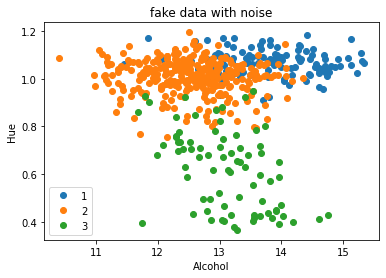

In [67]:
groups = df_fake_with_noise.groupby('Wine')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Alcohol, group.Hue, marker='o', linestyle='', ms=6, label=name)
ax.legend()
plt.title('fake data with noise')
plt.xlabel('Alcohol')
plt.ylabel('Hue')
plt.show()

Text(0, 0.5, 'Density')

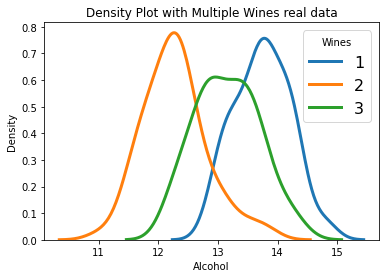

In [81]:
import seaborn as sns

# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df[df['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Alcohol'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines real data')
plt.xlabel('Alcohol')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

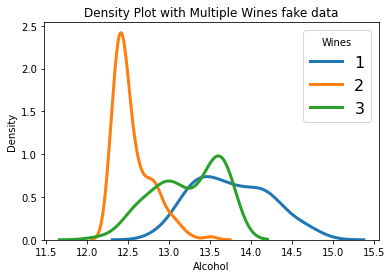

In [69]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake[df_fake['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Alcohol'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data')
plt.xlabel('Alcohol')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

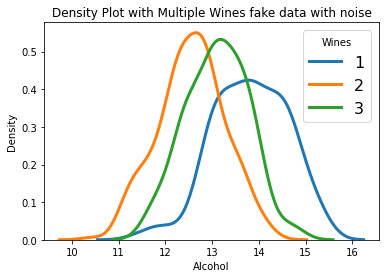

In [70]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake_with_noise[df_fake_with_noise['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Alcohol'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data with noise')
plt.xlabel('Alcohol')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

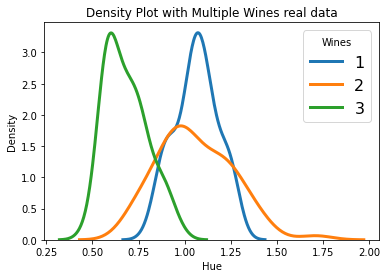

In [71]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df[df['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Hue'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines real data')
plt.xlabel('Hue')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

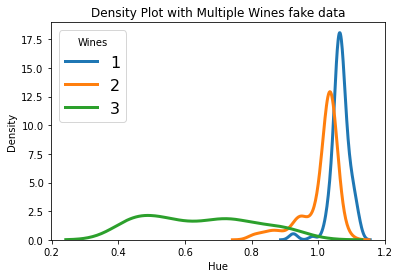

In [72]:
import seaborn as sns

# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake[df_fake['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Hue'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data')
plt.xlabel('Hue')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

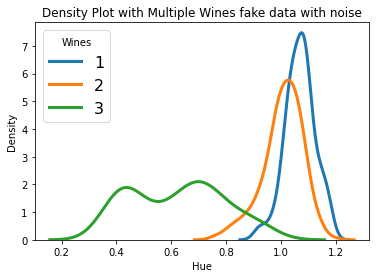

In [73]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake_with_noise[df_fake_with_noise['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Hue'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data with noise')
plt.xlabel('Hue')
plt.ylabel('Density')

In [74]:
df.columns

Index(['Wine', 'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
       'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue',
       'OD', 'Proline'],
      dtype='object')

Text(0, 0.5, 'Density')

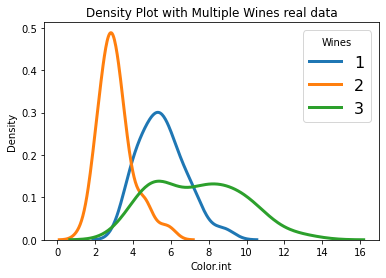

In [75]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df[df['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Color.int'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines real data')
plt.xlabel('Color.int')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

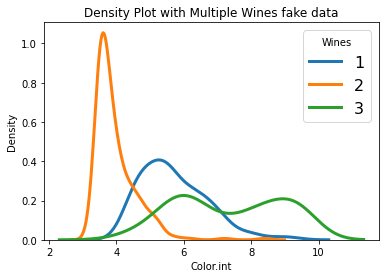

In [76]:
import seaborn as sns

# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake[df_fake['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Color.int'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data')
plt.xlabel('Color.int')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

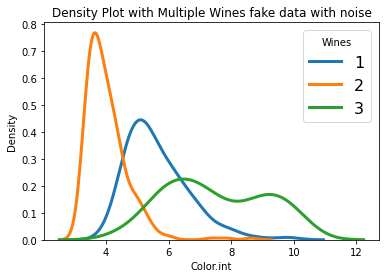

In [77]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake_with_noise[df_fake_with_noise['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Color.int'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data with noise')
plt.xlabel('Color.int')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

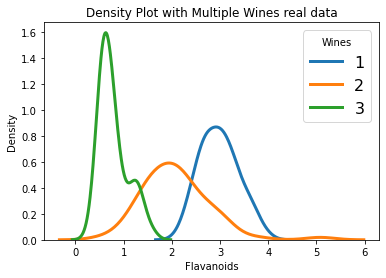

In [78]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df[df['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Flavanoids'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines real data')
plt.xlabel('Flavanoids')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

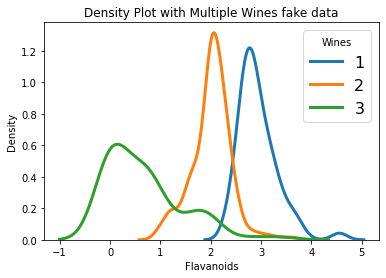

In [79]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake[df_fake['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Flavanoids'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data')
plt.xlabel('Flavanoids')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

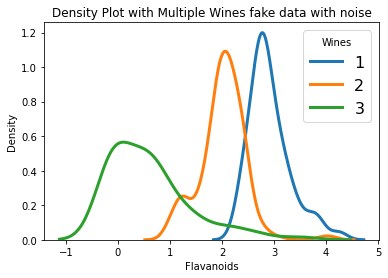

In [80]:
# List of wines
wines = [1,2,3]

for wine in wines:
    subset = df_fake_with_noise[df_fake_with_noise['Wine'] == wine]
    
    # Draw the density plot
    sns.distplot(subset['Flavanoids'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = wine)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Wines')
plt.title('Density Plot with Multiple Wines fake data with noise')
plt.xlabel('Flavanoids')
plt.ylabel('Density')